In [1]:
import argparse
import os
import shutil
import time

from fastai.transforms import *
from fastai.dataset import *
from fastai.fp16 import *
from fastai.conv_learner import *
from pathlib import *

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import models
from distributed import DistributedDataParallel as DDP

model_names = sorted(name for name in models.__dict__
                     if name.islower() and not name.startswith("__")
                     and callable(models.__dict__[name]))
# print(model_names)

# Example usage: python run_fastai.py /home/paperspace/ILSVRC/Data/CLS-LOC/ -a resnext_50_32x4d --epochs 1 -j 4 -b 64 --fp16

parser = argparse.ArgumentParser(description='PyTorch ImageNet Training')
parser.add_argument('data', metavar='DIR',
                    help='path to dataset')
parser.add_argument('--save-dir', type=str, default=Path.home()/'imagenet_training',
                    help='Directory to save logs and models.')
parser.add_argument('--arch', '-a', metavar='ARCH', default='resnet18',
                    choices=model_names,
                    help='model architecture: ' +
                    ' | '.join(model_names) +
                    ' (default: resnet18)')
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',
                    help='number of data loading workers (default: 4)')
parser.add_argument('--epochs', default=90, type=int, metavar='N',
                    help='number of total epochs to run')
# parser.add_argument('--start-epoch', default=0, type=int, metavar='N',
#                     help='manual epoch number (useful on restarts)')
parser.add_argument('-b', '--batch-size', default=256, type=int,
                    metavar='N', help='mini-batch size (default: 256)')
parser.add_argument('--lr', '--learning-rate', default=0.1, type=float,
                    metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M', help='momentum')
parser.add_argument('--weight-decay', '--wd', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)')
# parser.add_argument('--print-freq', '-p', default=10, type=int,
#                     metavar='N', help='print frequency (default: 10)')
parser.add_argument('--resume', default='', type=str, metavar='PATH',
                    help='path to latest checkpoint (default: none)')
parser.add_argument('-e', '--evaluate', dest='evaluate', action='store_true',
                    help='evaluate model on validation set')
parser.add_argument('--pretrained', dest='pretrained', action='store_true', help='use pre-trained model')
parser.add_argument('--fp16', action='store_true', help='Run model fp16 mode.')
parser.add_argument('--sz',       default=224, type=int, help='Size of transformed image.')
# parser.add_argument('--decay-int', default=30, type=int, help='Decay LR by 10 every decay-int epochs')
parser.add_argument('--loss-scale', type=float, default=1,
                    help='Loss scaling, positive power of 2 values can improve fp16 convergence.')
# parser.add_argument('--prof', dest='prof', action='store_true', help='Only run a few iters for profiling.')

parser.add_argument('--dist-url', default='file://sync.file', type=str,
                    help='url used to set up distributed training')
parser.add_argument('--dist-backend', default='nccl', type=str, help='distributed backend')

parser.add_argument('--world-size', default=1, type=int,
                    help='Number of GPUs to use. Can either be manually set ' +
                    'or automatically set by using \'python -m multiproc\'.')
parser.add_argument('--rank', default=0, type=int,
                    help='Used for multi-process training. Can either be manually set ' +
                    'or automatically set by using \'python -m multiproc\'.')


_StoreAction(option_strings=['--rank'], dest='rank', nargs=None, const=None, default=0, type=<class 'int'>, choices=None, help="Used for multi-process training. Can either be manually set or automatically set by using 'python -m multiproc'.", metavar=None)

In [2]:

def fast_loader(data_path, size):
    aug_tfms = [
        RandomFlip(),
#         RandomRotate(4),
#         RandomLighting(0.05, 0.05),
        RandomCrop(args.sz)
    ]
    tfms = tfms_from_stats(imagenet_stats, size, aug_tfms=aug_tfms, pad=args.sz//8)
    data = ImageClassifierData.from_paths(data_path, val_name='val', tfms=tfms, bs=args.batch_size, num_workers=args.workers)

    if args.distributed:
        train_sampler = torch.utils.data.distributed.DistributedSampler(data.trn_dl)
    else:
        train_sampler = None
        
    #### AS: REMEMBER TO TEST TRAIN SAMPLER
    #### should length of data prefetcher be the length of the sample?
    
    # Use pytorch default data loader. 20% faster
    data.trn_dl = torch.utils.data.DataLoader(
        data.trn_ds, batch_size=data.bs, shuffle=(train_sampler is None),
        num_workers=data.num_workers, pin_memory=True, sampler=train_sampler)
    data.trn_dl = DataPrefetcher(data.trn_dl)

    data.val_dl = torch.utils.data.DataLoader(
        data.val_ds,
        batch_size=data.bs, shuffle=False,
        num_workers=data.num_workers, pin_memory=True)
    data.val_dl = DataPrefetcher(data.val_dl)
    
    return data, train_sampler

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader):
        self.loader = loader
        self.loaditer = iter(loader)
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.preload()

    def __len__(self):
        return len(self.loader)
    
    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            yield input, target
            
# Taken from main.py topk accuracy
def top5(output, target):
    """Computes the precision@k for the specified values of k"""
    topk = 5
    batch_size = target.size(0)
    _, pred = output.topk(topk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    res = []
    correct_k = correct[:5].view(-1).float().sum(0, keepdim=True)
    return correct_k.mul_(100.0 / batch_size)

class ValLoggingCallback(Callback):
    def __init__(self, save_path):
        super().__init__()
        self.save_path=save_path
    def on_train_begin(self):
        self.batch = 0
        self.epoch = 0
        self.f = open(self.save_path, "a", 1)
    def on_epoch_end(self, metrics):
        log_str = f'\tEpoch:{self.epoch}\ttrn_loss:{self.last_loss}'
        for (k,v) in zip(['val_loss', 'acc', 'top5', ''], metrics): log_str += f'\t{k}:{v}'
        self.log(log_str)
        self.epoch += 1
    def on_batch_end(self, metrics):
        self.last_loss = metrics
        self.batch += 1
    def on_train_end(self):
        self.log("\ton_train_end")
        self.f.close()
    def log(self, string):
        self.f.write(time.strftime("%Y-%m-%dT%H:%M:%S")+"\t"+string+"\n")

# Logging + saving models
def save_args(name, save_dir):
    if (args.rank != 0) or not args.save_dir: return {}

    log_dir = f'{save_dir}/training_logs'
    m_dir = f'{save_dir}/models'
    tmp_dir = f'{save_dir}/tmp'
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(m_dir, exist_ok=True)
    os.makedirs(tmp_dir, exist_ok=True)

    m_dir_rel = os.path.relpath(m_dir, args.data)
    return {
        'best_save_name': f'{m_dir_rel}/{name}_best_model',
        'cycle_save_name': f'{m_dir_rel}/{name}',
        'tmp_name': os.path.relpath(tmp_dir, args.data),
        'callbacks': [
            LoggingCallback(f'{log_dir}/{name}_log.txt'),
            ValLoggingCallback(f'{log_dir}/{name}_val_log.txt')
        ]
    }

def save_sched(sched, save_dir):
    if not save_dir: return
    log_dir = f'{save_dir}/training_logs'
    sched.save_path = log_dir
    sched.plot_loss()
    sched.plot_lr()

In [6]:
fakeargs = ['/home/paperspace/data/imagenet', '-a', 'resnet50', '-j', '7', '--epochs', '100', '-b', '128', '--loss-scale', '128', '--fp16', '--save-dir', '/home/paperspace/data/test_saving']

In [7]:

# This is important for speed
cudnn.benchmark = True
global args
args = parser.parse_args(fakeargs)
print('Args:', args)

Args: Namespace(arch='resnet50', batch_size=128, data='/home/paperspace/data/imagenet', dist_backend='nccl', dist_url='file://sync.file', epochs=100, evaluate=False, fp16=True, loss_scale=128.0, lr=0.1, momentum=0.9, pretrained=False, rank=0, resume='', save_dir='/home/paperspace/data/test_saving', sz=224, weight_decay=0.0001, workers=7, world_size=1)


In [8]:

def main():
    args.distributed = args.world_size > 1
    args.gpu = 0
    if args.distributed:
        args.gpu = args.rank % torch.cuda.device_count()

    if args.distributed:
        torch.cuda.set_device(args.gpu)
        dist.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                                world_size=args.world_size)

    if args.fp16:
        assert torch.backends.cudnn.enabled, "fp16 mode requires cudnn backend to be enabled."

    # create model
    if args.pretrained:
        print("=> using pre-trained model '{}'".format(args.arch))
        model = models.__dict__[args.arch](pretrained=True)
    else:
        print("=> creating model '{}'".format(args.arch))
        model = models.__dict__[args.arch]()

    model = model.cuda()
    if args.distributed:
        model = DDP(model)
        
        
    # 160
    train_160 = True
    if train_160:
        data, train_sampler = fast_loader(f'{args.data}-160', 160)
    else:
        data, train_sampler = fast_loader(args.data, args.sz)

    learner = Learner.from_model_data(model, data)
    learner.crit = F.cross_entropy
    learner.metrics = [accuracy, top5]
    if args.fp16:
        learner.half()
        

    # 160x160
    if train_160:
        sargs = save_args('first_run', args.save_dir+'/160')
        learner.fit(args.lr,args.epochs, cycle_len=.005,
                    train_sampler=train_sampler,
                    wds=args.weight_decay,
                    use_clr=(20,2),
                    **sargs
                )
        save_sched(learner.sched, args.save_dir)
        data, train_sampler = fast_loader(args.data, args.sz)
        learner.set_data(data)


    # Full size
    sargs = save_args('first_run', args.save_dir)
    learner.fit(args.lr,args.epochs, cycle_len=.005,
                train_sampler=train_sampler,
                wds=args.weight_decay,
                use_clr=(20,2),
                **sargs
               )
    save_sched(learner.sched, args.save_dir)
    print('Finished!')
    

In [66]:
size=160
data_path=f'{args.data}-160'
aug_tfms = [
    RandomFlip(),
#         RandomRotate(4),
#         RandomLighting(0.05, 0.05),
    RandomCrop(size)
]
tfms = tfms_from_stats(imagenet_stats, size, aug_tfms=aug_tfms)
data = ImageClassifierData.from_paths(data_path, val_name='val', tfms=tfms, bs=args.batch_size, num_workers=args.workers)

if args.distributed:
    train_sampler = torch.utils.data.distributed.DistributedSampler(data.trn_dl)
else:
    train_sampler = None

#### TODO: Need to test train_sampler on distributed machines

In [67]:
data.trn_ds.fnames[0]

'train/n01440764/n01440764_11350.JPEG'

In [68]:
data.trn_ds[4][0].shape

(3, 160, 160)

TypeError: Invalid dimensions for image data

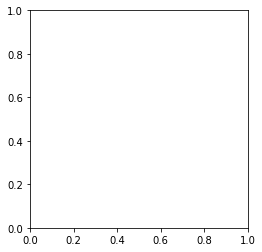

In [28]:
plt.imshow(data.trn_ds[0][0])

In [ ]:
next(iter(data.trn_dl))

In [17]:
# Use pytorch default data loader. 20% faster
data.trn_dl = torch.utils.data.DataLoader(
    data.trn_ds, batch_size=data.bs, shuffle=(train_sampler is None),
    num_workers=data.num_workers, pin_memory=True, sampler=train_sampler)

In [18]:
next(iter(data.trn_dl))

RuntimeError: Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 55, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 135, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 135, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 121, in default_collate
    return torch.stack([torch.from_numpy(b) for b in batch], 0)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/functional.py", line 64, in stack
    return torch.cat(inputs, dim)
RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 3 and 1 in dimension 2 at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/TH/generic/THTensorMath.c:2897


In [ ]:
data.trn_dl = DataPrefetcher(data.trn_dl)

In [11]:
data.val_dl = torch.utils.data.DataLoader(
    data.val_ds,
    batch_size=data.bs, shuffle=False,
    num_workers=data.num_workers, pin_memory=True)
data.val_dl = DataPrefetcher(data.val_dl)

RuntimeError: Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 55, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 135, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 135, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 121, in default_collate
    return torch.stack([torch.from_numpy(b) for b in batch], 0)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/functional.py", line 64, in stack
    return torch.cat(inputs, dim)
RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 160 and 6 in dimension 2 at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/TH/generic/THTensorMath.c:2897


In [ ]:
main()

In [29]:


def resize_img(fname, targ, path, new_path):
    dest = os.path.join(path,new_path,str(targ),fname)
    if os.path.exists(dest): return
    im = Image.open(os.path.join(path, fname)).convert('RGB')
    r,c = im.size
    ratio = targ/min(r,c)
    sz = (scale_to(r, ratio, targ), scale_to(c, ratio, targ))
    os.makedirs(os.path.split(dest)[0], exist_ok=True)
    im.resize(sz, Image.LINEAR).save(dest)

def resize_imgs(fnames, targ, path, new_path):
    if not os.path.exists(os.path.join(path,new_path,str(targ),fnames[0])):
        with ThreadPoolExecutor(16) as e:
            ims = e.map(lambda x: resize_img(x, targ, path, new_path), fnames)
            for x in tqdm(ims, total=len(fnames), leave=False): pass
    return os.path.join(path,new_path,str(targ))

def read_dir(path, folder):
    full_path = os.path.join(path, folder)
    fnames = glob(f"{full_path}/*.*")
    if any(fnames):
        return [os.path.relpath(f,path) for f in fnames]
    else:
        raise FileNotFoundError("{} folder doesn't exist or is empty".format(folder))

def read_dirs(path, folder):
    labels, filenames, all_labels = [], [], []
    full_path = os.path.join(path, folder)
    for label in sorted(os.listdir(full_path)):
        if label not in ('.ipynb_checkpoints','.DS_Store'):
            all_labels.append(label)
            for fname in os.listdir(os.path.join(full_path, label)):
                filenames.append(os.path.join(folder, label, fname))
                labels.append(label)
    return filenames, labels, all_labels

def scale_to(x, ratio, targ): return max(math.floor(x*ratio), targ)

def resize(targ, source_dir=None, resize_folder='resize'):
    if source_dir is None:
        source_dir = Path.home()/'data/imagenet'
    val_filenames, val_labels, val_all_labels = read_dirs(source_dir, 'val'); 
    print(f'Found {len(val_filenames)} validation images')

    train_filenames, train_labels, train_all_labels = read_dirs(source_dir, 'train'); len(train_filenames)
    print(f'Found {len(train_filenames)} training images')

    resize_imgs(train_filenames, targ, source_dir, resize_folder)
    resize_imgs(val_filenames, targ, source_dir, resize_folder)

In [31]:
source_dir = Path.home()/'data/imagenet'
val_filenames, val_labels, val_all_labels = read_dirs(source_dir, 'val'); 
print(f'Found {len(val_filenames)} validation images')

train_filenames, train_labels, train_all_labels = read_dirs(source_dir, 'train'); len(train_filenames)
print(f'Found {len(train_filenames)} training images')

Found 50000 validation images
Found 1281167 training images


In [33]:
targ=160
resize_folder = 'test_resize'

In [34]:
resize_imgs(train_filenames[:5], targ, source_dir, resize_folder)
# resize_imgs(val_filenames, targ, source_dir, resize_folder)

'/home/paperspace/data/imagenet/test_resize/160'

In [38]:
glob('/home/paperspace/data/imagenet/test_resize/160/train/*/*')

['/home/paperspace/data/imagenet/test_resize/160/train/n01440764/n01440764_11350.JPEG',
 '/home/paperspace/data/imagenet/test_resize/160/train/n01440764/n01440764_17514.JPEG',
 '/home/paperspace/data/imagenet/test_resize/160/train/n01440764/n01440764_9442.JPEG',
 '/home/paperspace/data/imagenet/test_resize/160/train/n01440764/n01440764_12090.JPEG',
 '/home/paperspace/data/imagenet/test_resize/160/train/n01440764/n01440764_9437.JPEG']

In [39]:
plt.imread('/home/paperspace/data/imagenet/test_resize/160/train/n01440764/n01440764_11350.JPEG').shape

(160, 240, 3)

In [47]:
plt.imread('/home/paperspace/data/imagenet-160/train/n01440764/n01440764_11350.JPEG').shape

(160, 240, 3)